
# **DEFINE PIPELINE FUNCTIONS**

In [25]:
# fungsi helper

def get_output_name(output_path):
  no_mp4 = output_path.strip(".mp4")
  nama_folder = ""
  for element in reversed(no_mp4):
    if element == "/":
      break
    nama_folder = nama_folder + element
  nama_folder = nama_folder[::-1]
  print(nama_folder)
  return (nama_folder)

In [2]:
output_path = "result/omagah_tuf_2.mp4"
file_name = get_output_name(output_path)
slow_output_path = "slowed/"+ file_name + "_slowed.mp4"
print (slow_output_path)

omagah_tuf_2
slowed/omagah_tuf_2_slowed.mp4


In [3]:
hehe = get_output_name("/content/gdrive/MyDrive/yolov4-tiny/video/result/omagah_agnes.mp4")

omagah_agnes


## 1. change FPS video (slower video)

In [4]:
def slow_down_video(input_path, output_path):
    import cv2
    video = cv2.VideoCapture(input_path)
    fps = video.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
    
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps

    print('fps = ' + str(fps))
    print('number of frames = ' + str(frame_count))
    print('duration (S) = ' + str(duration))
    minutes = int(duration/60)
    seconds = duration%60
    print('duration (M:S) = ' + str(minutes) + ':' + str(seconds))

    frame_width = int(video.get(3))
    frame_height = int(video.get(4))
      
    size = (frame_width, frame_height)

    # output_path itu untuk video yg ada bbox, jadi untuk yg slowdown pathnya dimodif dikit
    file_name = get_output_name(output_path)
    slow_output_path = "slowed/"+ file_name + "_slowed.mp4"
      
    # Below VideoWriter object will create a frame of above defined 
    # The output is stored in 'filename.avi' file.
    result = cv2.VideoWriter(slow_output_path, 
                            cv2.VideoWriter_fourcc(*'mp4v'),
                            30, size)
    
    # Untuk ngehitung frame yang asli (soalnya ada yang di tengah tengah ngereturn frame ghoib)
    x=0
    while(x<frame_count):
        ret, frame = video.read()
        print(str(x) + str(ret))
      
        if ret == True: 
            # Write the frame into the file 'filename.avi'
            result.write(frame)
            x+=1
      
        # Break the loop
    print ("==========UDAH BERES================")
    for i in range(60):
      ret, frame = video.read()
      print(str(x) + str(ret))
      x+=1

    video.release()
    result.release()
    cv2.destroyAllWindows()
      
    print("The video was successfully saved")
    return slow_output_path

## 2. ROI

In [26]:
def roi(frame, bbox):
    import cv2
    start = (0, 1080)
    end = (1920, 648)
    r = cv2.rectangle(frame, start, end, (0, 0, 0), 0)
    rect_img = frame[648:1080, 0:1920]
    y_middle= (bbox[3]-bbox[1])/2 + bbox[1]
#     x= (xmax - xmin)/2 + xmin
    if (y_middle < 648):
        return False, r
    else:
        return True, r

## 3. Object Detection

In [27]:
def detection_and_deepsort(input_path, model_path,score_threshold, iou_threshold, output_path, csv_path) :
  import os
  # comment out below line to enable tensorflow logging outputs
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  import csv
  import time
  import tensorflow as tf
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  if len(physical_devices) > 0:
      tf.config.experimental.set_memory_growth(physical_devices[0], True)
  from tensorflow.python.saved_model import tag_constants
  from PIL import Image
  import cv2
  import numpy as np
  import matplotlib.pyplot as plt
  from tensorflow.compat.v1 import ConfigProto
  from tensorflow.compat.v1 import InteractiveSession
  # deep sort imports
  from deep_sort import preprocessing, nn_matching
  from deep_sort.detection import Detection
  from deep_sort.tracker import Tracker
  from tools import generate_detections as gdet

  # Variabel penting
  flag_video = input_path
  flag_output = output_path
  flag_weights = model_path
  flag_score = score_threshold
  flag_iou = iou_threshold

  # Definition of the parameters
  max_cosine_distance = 0.4
  nms_max_overlap = 1.0

  # initialize deep sort
  model_filename = 'model/untuk_deepsort.pb'
  encoder = gdet.create_box_encoder(model_filename, batch_size=1)
  # calculate cosine distance metric
  metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, None)
  # initialize tracker
  tracker = Tracker(metric)

  # load configuration for object detector
  config = ConfigProto()
  config.gpu_options.allow_growth = True
  session = InteractiveSession(config=config)

  STRIDES = np.array([16, 32])
  ANCHORS = np.array([23,27, 37,58, 81,82, 81,82, 135,169, 344,319]).reshape(2,3,2)
  XYSCALE = [1.05, 1.05]
  NUM_CLASS = 1

  video_path = flag_video

  saved_model_loaded = tf.saved_model.load(flag_weights, tags=[tag_constants.SERVING])
  infer = saved_model_loaded.signatures['serving_default']

  # begin video capture
  vid = cv2.VideoCapture(video_path)

  out = None

  # get video ready to save locally if flag is set
  # by default VideoCapture returns float instead of int
  width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = int(vid.get(cv2.CAP_PROP_FPS))
  codec = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(flag_output, codec, fps, (width, height))

  frame_num = 0
  set_of_id = set()

  # untuk csv detail pothole
  header = ['pothole_id', 'frame', 'screenshoot', 'timestamp', 'real_size', 'total_count']
  f = open(csv_path, 'w')
  writer = csv.writer(f)
  array_of_data = []

  # untuk csv evaluasi
  header_eval = ['frame', 'actual', 'predicted', 'prob']
  f_eval = open("evaluation/untuk_eval_si_jerdy.csv", 'w')
  writer_eval = csv.writer(f_eval)
  array_of_data_eval = []

  def format_boxes(bboxes, image_height, image_width):
    for box in bboxes:
        ymin = int(box[0] * image_height)
        xmin = int(box[1] * image_width)
        ymax = int(box[2] * image_height)
        xmax = int(box[3] * image_width)
        width = xmax - xmin
        height = ymax - ymin
        box[0], box[1], box[2], box[3] = xmin, ymin, width, height
    return bboxes

  # while video is running
  while True:
      return_value, frame = vid.read()
      if return_value:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          image = Image.fromarray(frame)
      else:
          print('Video sudah selesai! Silahkan dicek. di '+ output_path)
          break
      frame_num +=1
      print('Frame #: ', frame_num)
      frame_size = frame.shape[:2]
      image_data = cv2.resize(frame, (416, 416))
      image_data = image_data / 255.
      image_data = image_data[np.newaxis, ...].astype(np.float32)
      start_time = time.time()

      # run detections on tflite if flag is set
      batch_data = tf.constant(image_data)
      pred_bbox = infer(batch_data)
      for key, value in pred_bbox.items():
        boxes = value[:, :, 0:4]
        pred_conf = value[:, :, 4:]

      boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
          boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
          scores=tf.reshape(
              pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
          max_output_size_per_class=50,
          max_total_size=50,
          iou_threshold=flag_iou,
          score_threshold=flag_score
      )

      # convert data to numpy arrays and slice out unused elements
      num_objects = valid_detections.numpy()[0]
      bboxes = boxes.numpy()[0]
      bboxes = bboxes[0:int(num_objects)]
      scores = scores.numpy()[0]
      scores = scores[0:int(num_objects)]
      classes = classes.numpy()[0]
      classes = classes[0:int(num_objects)]

      # format bounding boxes from normalized ymin, xmin, ymax, xmax ---> xmin, ymin, width, height
      original_h, original_w, _ = frame.shape
      bboxes = format_boxes(bboxes, original_h, original_w)

      # store all predictions in one parameter for simplicity when calling functions
      pred_bbox = [bboxes, scores, classes, num_objects]

      # ngeappend ke array untuk ke csv evaluasi
      if len(scores) != 0:
        data_eval = [frame_num, "", "pothole", scores]
        array_of_data_eval.append(data_eval)
      
      names=['pothole']

      # encode yolo detections and feed to tracker
      features = encoder(frame, bboxes)
      detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in zip(bboxes, scores, names, features)]

      #initialize color map
      cmap = plt.get_cmap('tab20b')
      colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

      # run non-maxima supression
      boxs = np.array([d.tlwh for d in detections])
      scores = np.array([d.confidence for d in detections])
      classes = np.array([d.class_name for d in detections])
      indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
      detections = [detections[i] for i in indices]

      frame,array_of_data,set_of_id,tracker = deep_sort(tracker,detections,colors,frame,
                                                        set_of_id,vid,frame_num,array_of_data,True, output_path)
      
      # calculate frames per second of running detections
      fps = 1.0 / (time.time() - start_time)
      print("FPS: %.2f" % fps)
      result = np.asarray(frame)
      result = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      
      
      # if output flag is set, save video file
      out.write(result)
      if cv2.waitKey(1) & 0xFF == ord('q'): break
  
  writer.writerow(header)
  writer.writerows(array_of_data)

  writer_eval.writerow(header_eval)
  writer_eval.writerows(array_of_data_eval)

  f.close()
  f_eval.close()

  out.release()
  cv2.destroyAllWindows()
  return output_path

## 4. DeepSort

In [28]:
def deep_sort(tracker,detections,colors,frame,set_of_id,vid,frame_num,array_of_data,flag_info, output_path):
  import cv2
  # Call the tracker
  tracker.predict()
  tracker.update(detections)

  # update tracks
  for track in tracker.tracks:
      if not track.is_confirmed() or track.time_since_update > 1:
          continue 
      bbox = track.to_tlbr()
      class_name = track.get_class()

      inside_roi, frame = roi(frame, bbox)
      if not inside_roi:
        continue

      # draw bbox on screen
      frame = boundingBox(track, colors, frame, bbox, class_name)

      if (track.track_id not in set_of_id):
        set_of_id.add(track.track_id)

        # Panggil panggil fungsi
        ss_path = screenshot(frame, track.track_id, output_path)
        time_stamp = str(timestamps(vid))
        real_size = measure_bbox(int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
        current_count = counting(set_of_id)

        data = [track.track_id, frame_num, ss_path, time_stamp, real_size, current_count]
        array_of_data.append(data)

      # if enable info flag then print details about each track
      if flag_info:
          print("Tracker ID: {}, Class: {},  BBox Coords (xmin, ymin, xmax, ymax): {}".format(str(track.track_id), class_name, (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))))
  return(frame,array_of_data,set_of_id,tracker)

## 5. Counting

In [29]:
def counting(set_of_id):
  return len(set_of_id)

## 6. boundingbox

In [30]:
def boundingBox(track, colors, frame, bbox, class_name):
  import numpy as np
  import cv2
  color = colors[int(track.track_id) % len(colors)]
  color = [i * 255 for i in color]
  cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
  cv2.rectangle(frame, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)+len(str(track.track_id)))*17, int(bbox[1])), color, -1)
  cv2.putText(frame, class_name + "-" + str(track.track_id),(int(bbox[0]), int(bbox[1]-10)),0, 0.75, (255,255,255),2)
  return frame

## 7. Measure bounding box area

In [32]:
def measure_bbox(xmin,xmax,ymin,ymax):

  #ini kalo 0,0 di kiri atas
  temp = ymin
  ymin = 1080 - ymax
  ymax = 1080 - temp
  
  # https://pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/
  # https://stackabuse.com/3d-object-detection-3d-bounding-boxes-in-python-with-mediapipe-objectron/
  # kalo ini pake cara "berapa panjang dan jauh kamera memandang"
  # dengan konsep trapesium terbalik

  #       A_________________________________B  "ROI (432 px)" measured 3192, 774194 cm
  #        \                               /
  #         \                             / 
  #          \                           /
  #          E\_________hole____________/F
  #            \                       /
  #             \_____________________/       "Camera Position (0px)" measured 480cm 
  #             D                     C       The height of this trapesium is the distance from the camera to ROI, measured 663,65217 cm

  # By get EF length, we can get the scale of 1 px to real size
  # EF = ((DCxAE) + (ABxDE))/(AE + DE)

  #       A________H        DH = 1470 (432 pixel)
  #        \       |        AH = (AB-DC)/2 
  #         \      |           = 1356 cm
  #          \     |        by phytagoras theorem we get AD, 1509 cm
  #           \    |          
  #           E\___|G        
  #             \  |                    
  #              \ |
  #               D

  # DH, CD, Lebar Jalan perlu dicek lagi

  #Known
  AB = 2443.85185
  CD = 455
  AD = 1774.726278
  ROI_px = 432 
  video_width = 1920
  video_height = 1080

  x_hole_px = xmax-xmin
  y_hole_px = ymax-ymin

  
  #Ask
  #EF -> real size of x_hole
  
  DE = (ymin/ROI_px)*AD
  AE = AD-DE
  EF = ((CD*AE)+(AB*DE))/(AE+DE)
  print(EF)

  #lebar sebenarnya atau x_hole
  x_hole = EF*(x_hole_px/video_width)

  #lalu bagaimana dengan y_hole?
  #konsep percepatan tapi kecepatannya adalah panjang jalan dan waktunya adalah pixel, makin kecil pixel, makin besar percepatan
  # variabel penentu : jarak sebenarnya = d
  #                    tinggi pixel = t
  #                    kecepatan (V) = d/t
  #                    percepatan (a) = d/t^2 
  # a = 424cm/(276^2)px
  # Xt (jarak sebenarnya ditempuh dalam t pixel) = X0 (jarak awal ketika 0 pixel) + Vo (kecepatan saat t pixel) . t + 1/2 (a [percepatan] . t^2)                 
  # y_hole (jarak sebenarnya dari ymin ke ymax) = Xymax - Xymin
  # Xymax = Vymax .t_ymax + 1/2 (a).t_ymax^2
  # Xymin = Vymin .t_ymin + 1/2 (a).t_ymin^2
  # Vymax = v0 + a.t
  #      = (424/276^2).t_ymax
  # Vymin = v0 + a.t
  #      = (424/276^2).t_ymin 
  # y_hole = (Vymax .t_ymax + 1/2 (a).t_ymax^2)-(Vymin .t_ymin + 1/2 (a).t_ymin^2)
  #        = ((424/276^2).t_ymax .t_ymax + 1/2 (a).t_ymax^2)-((424/276^2).t_ymin .t_ymin + 1/2 (a).t_ymin^2)

  a = 424/(276**2)
  a2 = 810/(432**2)
  a3 = ((810/432) - (424/276))/(432-276)
  Vymax = (424/(276**2))*ymax
  Vymin = (424/(276**2))*ymin
  Xymax = (Vymax*ymax) + (0.5)*(a3*(ymax)**2)
  Xymin = (Vymin*ymin) + (0.5)*(a3*(ymin)**2)

  print("ymax, ymin, xmax, xmin, x_hole_px, y_hole_px : ", ymax, ymin, xmax, xmin, x_hole_px, y_hole_px)
  y_hole = Xymax-Xymin

  return (abs(x_hole*y_hole))

In [20]:
# PUNYA BOKI
def measure_bbox(xmin, ymin, xmax, ymax):
    # Perbandingan nilai Delta X / Delta Y reference
    MultipliedValue = 0.5595
    
    # Nilai reference
    y_reference = 953
    deltaX_reference = 229

    # Dilai Delta X dan Delta Y data
    deltaY_data = ymax - ymin
    deltaX_data = xmax - xmin

    # Faktor pengali agar fungsi dapat bekerja pada BB non-persegi
    notSquare = 2.7*deltaY_data/deltaX_data

    if (ymax > y_reference) :
        deltaY = ymax - y_reference
        deltaX = deltaY * MultipliedValue
        xResult = deltaX_reference + deltaX
    else :
        deltaY = ymax - y_reference
        deltaX = deltaY * MultipliedValue
        xResult = deltaX_reference - deltaX

    # Nilai asli X (cm)   
    xReal = deltaX_data/xResult*60
    
    # Luas total area (cm^2)
    return (xReal*xReal*notSquare)

## 8. screenshoot

In [33]:
def screenshot(frame, pothole_id, output_path):
  import cv2, os
  # start helper function
  nama_folder = get_output_name(output_path)
  path_folder = "ss_" + nama_folder
  if not os.path.isdir("result/" + path_folder):
   os.makedirs("result/" + path_folder)
  path_ss = "result/" + str(path_folder) + "/" + str(pothole_id) + ".png"
  full_color = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
  cv2.imwrite(path_ss, full_color)
  return path_ss

## 9. timestamps

In [34]:
def timestamps(vid):
  import datetime
  import cv2
  cap = vid
  ms = cap.get(cv2.CAP_PROP_POS_MSEC)
  print("Milisecond: "+str(ms))
  bentuk_dt = datetime.timedelta(seconds=ms/1000)
  print(str(bentuk_dt)[:-3])
  print("Timestamp: "+str(bentuk_dt)[:-3])
  return(str(bentuk_dt)[:-3]+"")

In [19]:
import datetime
ms = 112234353253243.3333333333333
print("Milisecond: "+str(ms))
bentuk_dt = datetime.datetime.fromtimestamp(ms/1000.0).strftime('%H:%M:%S.%f')
print(bentuk_dt)

Milisecond: 112234353253243.33
00:14:13.243332


In [21]:
import datetime
ms = 11323223233.3333333333333
print("Milisecond: "+str(ms))
bentuk_dt = datetime.timedelta(seconds=ms/1000)
print(str(bentuk_dt)[:-3])

Milisecond: 11323223233.333334
131 days, 1:20:23.233


In [20]:
!pip install datetime --upgrade

     |████████████████████████████████| 52 kB 289 kB/s eta 0:00:011
     |████████████████████████████████| 261 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 498 kB 59.7 MB/s eta 0:00:01


## 10. metriks(confusion matrix: accuracy, precision, F1score, recalll)

In [9]:
def evaluation(path_to_csv):
  import csv
  results = []
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  with open(path_to_csv) as csvfile:
      reader = csv.reader(csvfile) # change contents to floats
      next(reader, None)
      for row in reader:
        if (row[1] == "pothole" and row[2] == "pothole"):
          tp = tp +1
        elif (row[1] == "none" and row[2] == "none"):
          tn = tn +1
        elif (row[1] == "none" and row[2] == "pothole"):
          fp = fp + 1
        else:
          fn = fn + 1

  print("TP:",tp,"    TN:",tn,"    FP:",fp,"    FN:",fn)
  accuracy=round((tp+tn)/(tp+tn+fp+fn),3)
  precision=round(tp/(tp+fp),3) 
  recall=round(tp/(tp+fn),3)
  f1= round(2*((precision*recall)/(precision+recall)),3)
  print("Accuracy:",accuracy,"\t Precision:",precision,"\t Recall:",recall, "\t F1 score:",f1)
  
  return accuracy, precision, recall, f1

In [ ]:
accuracy, precision, recall, f1 = evaluation("evaluation/untuk_eval_si_jerdy (1).csv")

TP: 89     TN: 0     FP: 539     FN: 0
Accuracy: 0.142 	 Precision: 0.142 	 Recall: 1.0 	 F1 score: 0.249


## **Fungsi pipeline nya**

In [ ]:
# blom ada

# **JALANIN PIPELINE ASLIAN**

In [ ]:
%pip install -r requirements.txt 
# pencet Restart Runtime kalo udah selesai

In [3]:
import os
# comment out below line to enable tensorflow logging outputs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.python.client import device_lib
print("Versi tensorflow adalah " + tf.__version__ + "\n")
print(device_lib.list_local_devices())

Versi tensorflow adalah 2.7.0

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2334291120268061293
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2768502784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7577528679291485365
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Ngepake pipeline yang udah didefine di atas

In [35]:
print("Start") # Biar bisa keliatan progressnya (kalo dijalanin di vscode)

hasil = detection_and_deepsort("slowed/1_slowed.mp4",
                       "model/pothole", 
                       0.4, 1.0,
                       "result/punya_furkon.mp4",
                       "result/punya_furkon.csv")

Start
Frame #:  1
FPS: 0.21
Frame #:  2
FPS: 45.13
Frame #:  3
FPS: 40.46
Frame #:  4
FPS: 36.31
Frame #:  5
FPS: 38.05
Frame #:  6
FPS: 32.55
Frame #:  7
FPS: 45.16
Frame #:  8
FPS: 36.98
Frame #:  9
FPS: 46.79
Frame #:  10
FPS: 33.64
Frame #:  11
FPS: 42.75
Frame #:  12
FPS: 33.54
Frame #:  13
FPS: 31.05
Frame #:  14
FPS: 31.88
Frame #:  15
FPS: 46.19
Frame #:  16
FPS: 35.30
Frame #:  17
FPS: 49.46
Frame #:  18
FPS: 33.53
Frame #:  19
FPS: 48.85
Frame #:  20
FPS: 50.50
Frame #:  21
FPS: 40.86
Frame #:  22
FPS: 39.06
Frame #:  23
FPS: 47.25
Frame #:  24
FPS: 39.01
Frame #:  25
FPS: 43.46
Frame #:  26
FPS: 44.00
Frame #:  27
FPS: 37.57
Frame #:  28
FPS: 42.80
Frame #:  29
FPS: 31.07
Frame #:  30
FPS: 41.33
Frame #:  31
FPS: 36.11
Frame #:  32
FPS: 52.27
Frame #:  33
FPS: 1.71
Frame #:  34
FPS: 26.33
Frame #:  35
punya_furkon
Milisecond: 1133.3333333333333
0:00:01.133
Timestamp: 0:00:01.133
542.4726508101852
ymax, ymin, xmax, xmin, x_hole_px, y_hole_px :  -520 19 850 1236 -386 -539
Trac

In [44]:
print("Start")
vid_path = slow_down_video("input/3.mp4", "result/3.mp4")
print(vid_path)

Start
fps = 59.94005994005994
number of frames = 15931
duration (S) = 265.78218333333336
duration (M:S) = 4:25.782183333333364
3
0True
1True


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


2True
3True
4True
5True
6True
7True
8True
9True
10True
11True
12True
13True
14True
15True
16True
17True
18True
19True
20True
21True
22True
23True
24True
25True
26True
27True
28True
29True
30True
31True
32True
33True
34True
35True
36True
37True
38True
39True
40True
41True
42True
43True
44True
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45False
45True
46True
47True
48True
49True
50True
51True
52True
53True
54True
55True
56True
57True
58True
59True
60True
61True
62True
63True
64True
65True
66True
67True
68True
69True
70True
71True
72True
73True
74True
75True
76True
77True
78True
79True
80True
81True
82True
8

In [11]:
def measure_bbox(a, b, c, d):
  return "huhu"

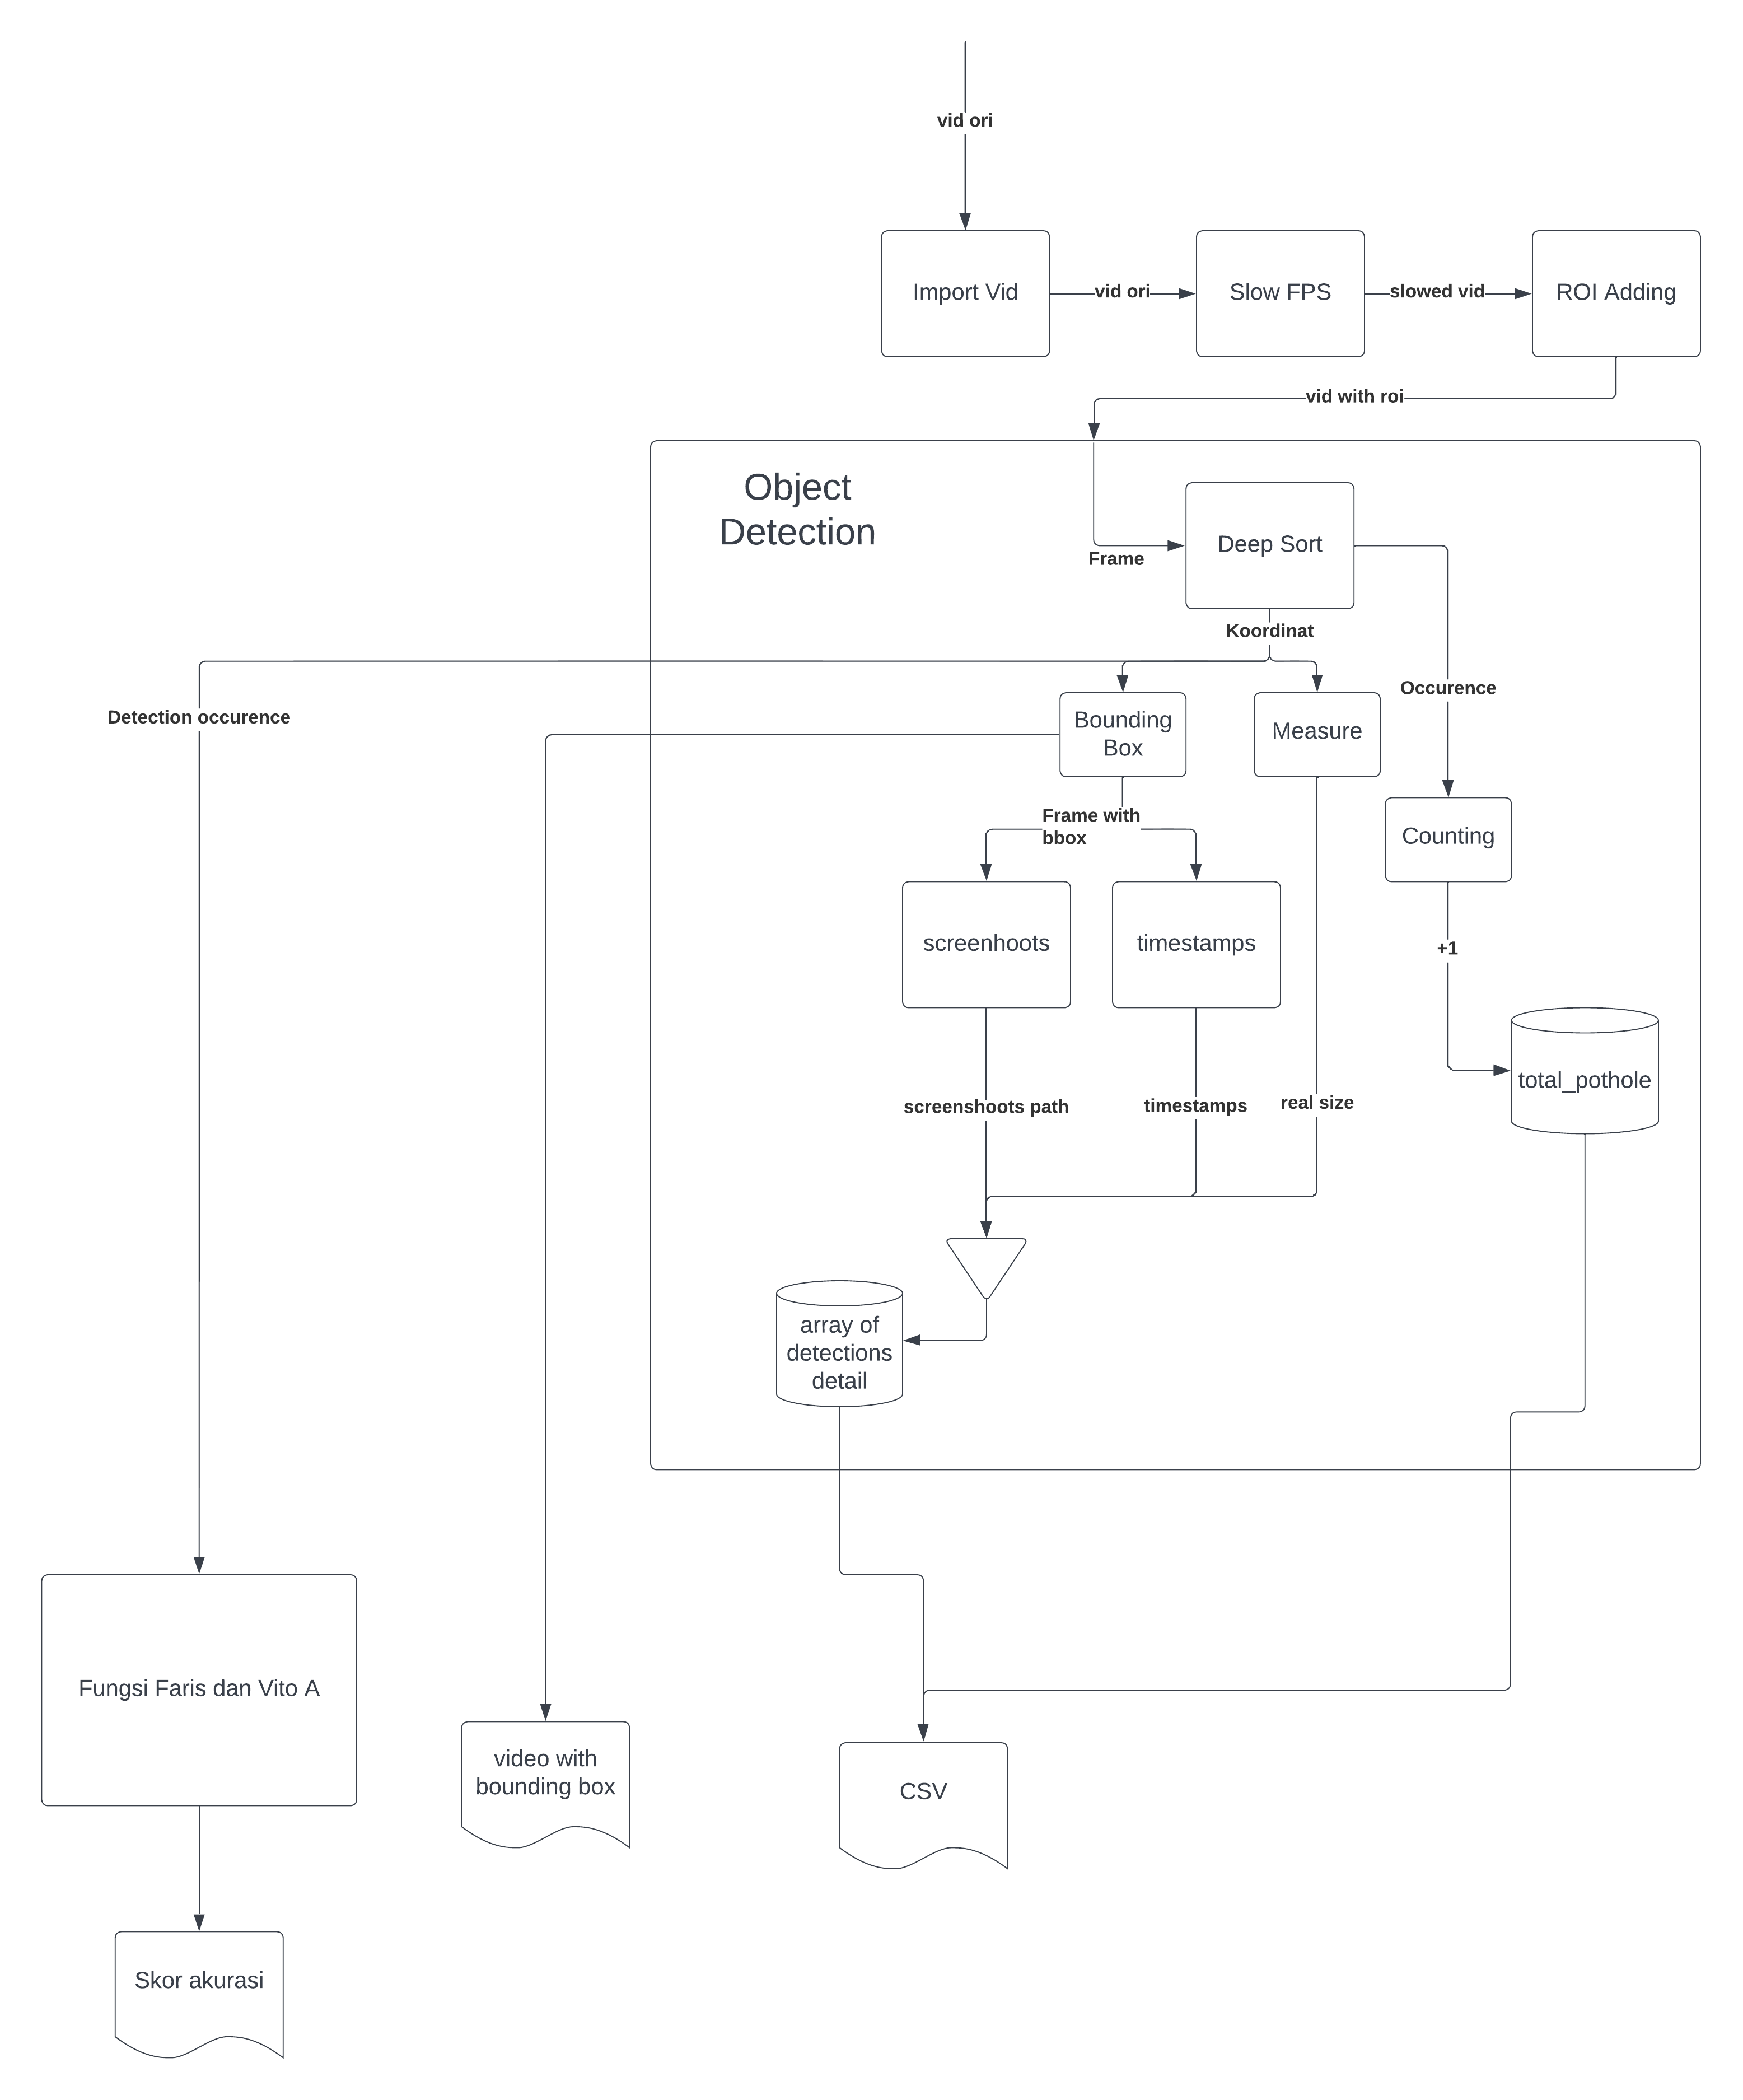